![DSME-logo](../img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# NARX Model of the Cartpole Environment

In the following we will train a nonlinear autoregressive exogenous dynamics model (NARX) for the cartpole environment using a feedforward neural network.<br>
![cartpole](./img/cartpole.png)

## Library Imports

In [1]:
%matplotlib inline
import gymnasium as gym
import numpy as np
import control as ct
import math
import custom_envs
import matplotlib
import matplotlib.pyplot as plt
from typing import Optional, Union
from IPython.display import Video
from IPython.display import display
from matplotlib.animation import FuncAnimation
from gymnasium import logger, spaces
from gymnasium.envs.classic_control import utils
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Initialize Environment

First, we initialize the cartpole environment. For controlling the system, we synthesize a linear quadratic regulator (LQR).

In [2]:
env = gym.make('CustomCartPole-v2', render_mode='rgb_array').unwrapped

cartpole = ct.NonlinearIOSystem(env.ct_sys_update, env.ct_sys_output, states=4, name='cartpole', inputs=['action'], outputs=['x', 'x_dot', 'theta', 'theta_dot'])
linsys = cartpole.linearize(x0=np.array([0., 0., 0., 0.]), u0=np.array([0.]))
linsys_d = linsys.sample(env.tau)

cost_x = 5
cost_x_dot = 1
cost_theta = 10
cost_theta_dot = 1
cost_control = 1

Q = np.diag([cost_x, cost_x_dot, cost_theta, cost_theta_dot])
R = np.diag([cost_control])

K, _, _ = ct.lqr(linsys_d, Q, R)

## Generate Dataset

Next, we collect data from the system. We start the cartpole with different initial conditions and stabilize it using the LQR controller. We save the encountered states, actions and when a trajectory terminates.

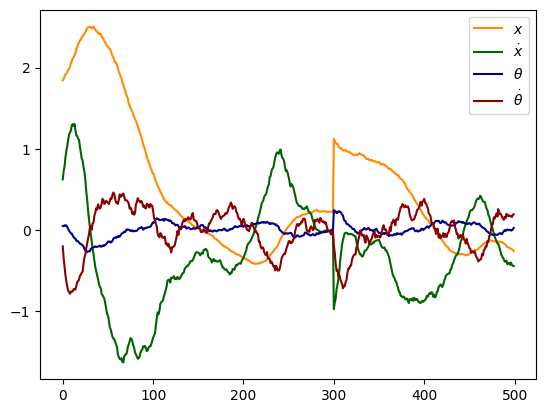

In [3]:
total_steps = 500 #100000
max_ep_steps = 300
steps = 0
ep_steps = 0
act_arr = np.zeros([total_steps, 1])
obs_arr = np.zeros([total_steps, 4])
done_arr = np.zeros(total_steps)

while steps < total_steps:
    x_0 = np.random.uniform(low=0.0, high=2.0) # Sample start state
    x_dot_0 = np.random.uniform(low=-1, high=1)
    theta_0 = np.random.uniform(low=-45, high=45) * 2 * math.pi / 360
    theta_dot_0 = np.random.uniform(low=-20, high=20) * 2 * math.pi / 360

    start_state = np.array([x_0, x_dot_0, theta_0, theta_dot_0 ])
    done = False
    state, _ = env.reset(start_state=start_state.copy())
    #frames = []  # collect rgb_image of agent env interaction

    while not done:
        action = -np.matmul(K, state)[0] # apply control action (the LQR acts as the policy)
        next_state, reward, done, _, _ = env.step(action) # simulate the system
        act_arr[steps] = action # store the data
        obs_arr[steps, :] = state
        done_arr[steps] = done
        state = next_state
        steps += 1
        ep_steps += 1
        if ep_steps == max_ep_steps:
            done = True
            done_arr[steps-1] = done
            ep_steps = 0
        if steps == total_steps:
            break


plt.plot(obs_arr[:, 0], label='$x$', color='darkorange')
plt.plot(obs_arr[:, 1], label='$\dot{x}$', color='darkgreen')
plt.plot(obs_arr[:, 2], label='$\\theta$', color='darkblue')
plt.plot(obs_arr[:, 3], label='$\dot{\\theta}$', color='darkred')
plt.legend(loc='upper right')
plt.show()

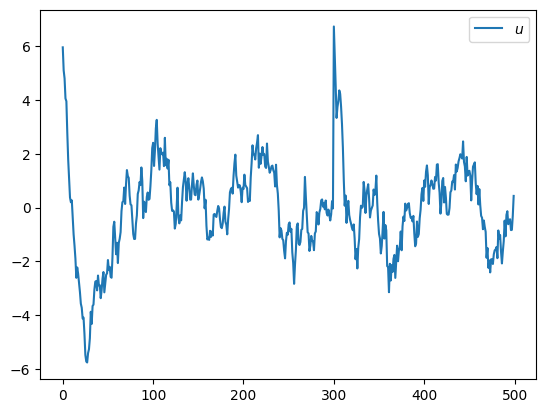

In [4]:
plt.plot(act_arr, label='$u$')
plt.legend(loc='upper right')
plt.show()

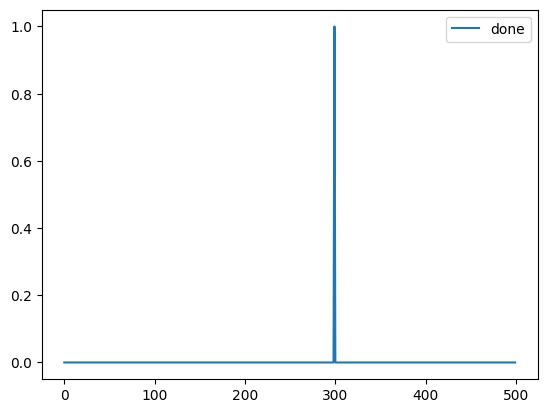

In [5]:
plt.plot(done_arr, label='done')
plt.legend(loc='upper right')
plt.show()

## Define model input

Here we define the history of controls and observations we consider for the NARX model input. <br>
$y(t)=F(\phi(t))=F(y(t-1), y(t-2), \ldots, u(t-1), u(t-2), \ldots)$

In [6]:
hist_obs = 5
hist_act = 3
win_len = max(hist_obs, hist_act) + 1

## Compute Training Data

Based on the input specifications, compute features and labels for training the neural network.

In [7]:
features = np.zeros([total_steps, hist_obs * obs_arr.shape[1] + hist_act * act_arr.shape[1]])
labels = np.zeros([total_steps, obs_arr.shape[1]])

j=0
for i in range(win_len, total_steps):
    if np.sum(done_arr[i-win_len:i]) < 1e-6:
        labels[j] = obs_arr[i, :]
        features[j] = np.concatenate((obs_arr[i-hist_obs:i, :].flatten(), act_arr[i-hist_act:i, :].flatten()), axis=0)
        j += 1
features = features[:j, :]
labels = labels[:j, :]

with open('features.npy', 'wb') as f:
    np.save(f, features)
with open('labels.npy', 'wb') as f:
    np.save(f, labels)

## Prepare Training Data

Shuffle the dataset and split it into training and test data.

In [8]:
with open('features.npy', 'rb') as f:
    features = np.load(f)
with open('labels.npy', 'rb') as f:
    labels = np.load(f)


dataset = TensorDataset(torch.from_numpy(features).type(torch.FloatTensor), torch.from_numpy(labels).type(torch.FloatTensor))
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Define neural network architecture

In [9]:
class Net(nn.Module):
    def __init__(self, state_dim, state_hist, act_dim, act_hist):
        super().__init__()
        self.fc1 = nn.Linear(state_dim*state_hist+act_dim*act_hist, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, state_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Define Neural Network Parameters

In [10]:
net = Net(state_dim=4, state_hist=hist_obs, act_dim=1, act_hist=hist_act)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
num_epochs = 200
train_loss = np.zeros(num_epochs)
test_loss = np.zeros(num_epochs)

early_stopping_patience = 3
min_improvement = 1e-4

## Train Neural Network

epoch: 0, train loss: 0.7183290719985962
epoch: 0, test loss: 5.56073260307312
epoch: 1, train loss: 0.6645004451274872
epoch: 1, test loss: 5.197892189025879
epoch: 2, train loss: 0.7739366640647253
epoch: 2, test loss: 5.8662876188755035
epoch: 3, train loss: 0.790456642707189
epoch: 3, test loss: 5.94122713804245
epoch: 4, train loss: 0.7317104289929072
epoch: 4, test loss: 5.550157755613327
epoch: 5, train loss: 0.7485913932323456
epoch: 5, test loss: 5.755918920040131
epoch: 6, train loss: 0.6383923590183258
epoch: 6, test loss: 4.9217469692230225
epoch: 7, train loss: 0.6406739950180054
epoch: 7, test loss: 4.9457820653915405
epoch: 8, train loss: 0.5908545975883802
epoch: 8, test loss: 4.639835074543953
epoch: 9, train loss: 0.6608775208393732
epoch: 9, test loss: 5.149874806404114
epoch: 10, train loss: 0.6753280808528265
epoch: 10, test loss: 5.090060293674469
Finished Training


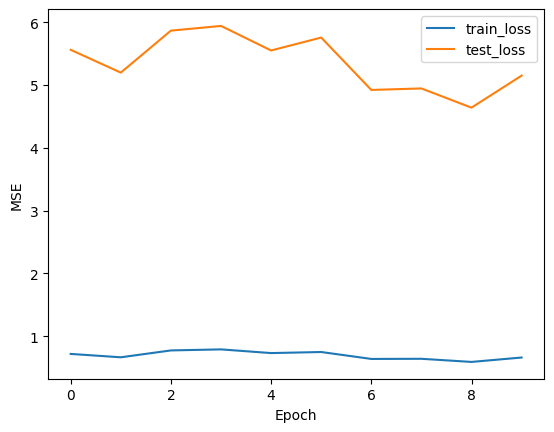

In [11]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    ep_train_loss = running_loss / i
    print('epoch: '+str(epoch) + ', train loss: '+str(ep_train_loss))
    train_loss[epoch] = ep_train_loss

    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, labels)
        running_loss += loss.item()
    ep_test_loss = running_loss / i
    print('epoch: ' + str(epoch) + ', test loss: ' + str(ep_test_loss))
    test_loss[epoch] = ep_test_loss

    # early stopping
    if epoch > early_stopping_patience and test_loss[epoch] >= np.max(test_loss[epoch-1-early_stopping_patience:epoch-1])-min_improvement:
        break

print('Finished Training')
plt.plot(train_loss[:epoch], label='train_loss')
plt.plot(test_loss[:epoch], label='test_loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

torch.save(net.state_dict(), './net_notebook.pth')

## Load Neural Network

In [12]:
net = Net(state_dim=4, state_hist=hist_obs, act_dim=1, act_hist=hist_act)
net.load_state_dict(torch.load('./net_notebook.pth', weights_only=True))

<All keys matched successfully>

## Collect Evaluation Trajectory

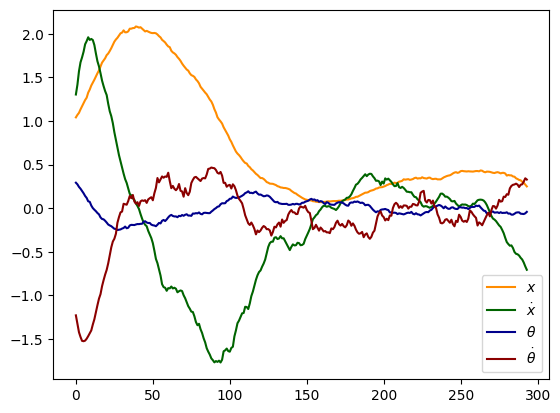

In [13]:
max_ep_steps = 300
ep_steps = 0
act_arr = np.zeros([max_ep_steps, 1])
obs_arr = np.zeros([max_ep_steps, 4])
done_arr = np.zeros(max_ep_steps)

x_0 = 1.0
x_dot_0 = -0.2
theta_0 = 20 * 2 * math.pi / 360
theta_dot_0 = 10 * 2 * math.pi / 360

start_state = np.array([x_0, x_dot_0, theta_0, theta_dot_0 ])
done = False
state, _ = env.reset(start_state=start_state.copy())

while not done:
    action = -np.matmul(K, state)[0]
    next_state, reward, done, _, _ = env.step(action)
    act_arr[ep_steps] = action
    obs_arr[ep_steps, :] = state
    done_arr[ep_steps] = done
    #out = env.render()
    #frames.append(out)
    state = next_state
    ep_steps += 1
    if ep_steps == max_ep_steps:
        done = True
        done_arr[ep_steps-1] = done
        break

plt.plot(obs_arr[win_len:, 0], label='$x$', color='darkorange')
plt.plot(obs_arr[win_len:, 1], label='$\dot{x}$', color='darkgreen')
plt.plot(obs_arr[win_len:, 2], label='$\\theta$', color='darkblue')
plt.plot(obs_arr[win_len:, 3], label='$\dot{\\theta}$', color='darkred')
plt.legend(loc='lower right', ncol=1)
plt.show()

In [14]:
features = np.zeros([max_ep_steps, hist_obs * obs_arr.shape[1] + hist_act * act_arr.shape[1]])
labels = np.zeros([max_ep_steps, obs_arr.shape[1]])
j=0
for i in range(win_len, max_ep_steps):
    if np.sum(done_arr[i-win_len:i]) < 1e-6:
        labels[j] = obs_arr[i, :]
        features[j] = np.concatenate((obs_arr[i-hist_obs:i, :].flatten(), act_arr[i-hist_act:i, :].flatten()), axis=0)
        j += 1
features = features[:j, :]
labels = labels[:j, :]

features = torch.from_numpy(features).type(torch.FloatTensor)
act_arr = torch.from_numpy(act_arr).type(torch.FloatTensor)
obs_arr = torch.from_numpy(obs_arr).type(torch.FloatTensor)

## One-step predictions with the model

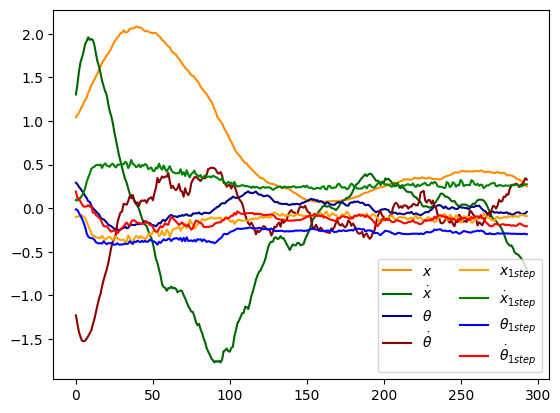

In [15]:
with torch.no_grad():
    one_step_preds = net(features)
plt.plot(obs_arr[win_len:, 0], label='$x$', color='darkorange')
plt.plot(obs_arr[win_len:, 1], label='$\dot{x}$', color='darkgreen')
plt.plot(obs_arr[win_len:, 2], label='$\\theta$', color='darkblue')
plt.plot(obs_arr[win_len:, 3], label='$\dot{\\theta}$', color='darkred')

plt.plot(one_step_preds[:, 0], label='$x_{1 step}$', color='orange')
plt.plot(one_step_preds[:, 1], label='$\dot{x}_{1 step}$', color='green')
plt.plot(one_step_preds[:, 2], label='$\\theta_{1 step}$', color='blue')
plt.plot(one_step_preds[:, 3], label='$\dot{\\theta}_{1 step}$', color='red')
plt.legend(loc='lower right', ncol=2)
plt.show()

## Predict the full trajectory with the model

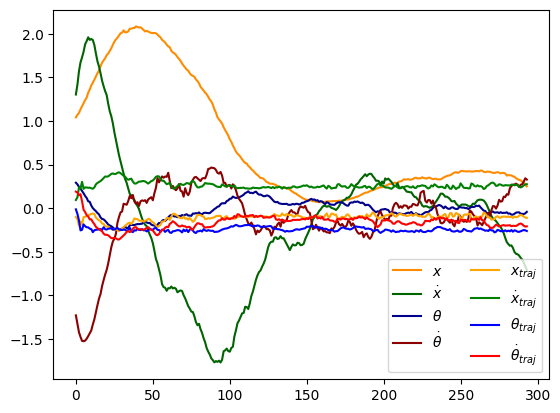

In [16]:
pred_arr = torch.zeros(max_ep_steps, 4)
pred_arr[win_len-hist_obs:win_len, :] = obs_arr[win_len-hist_obs:win_len, :]

for i in range(win_len, max_ep_steps):
    feature = torch.concat((pred_arr[i-hist_obs:i, :].flatten(), act_arr[i-hist_act:i, :].flatten()), dim=0)
    with torch.no_grad():
        pred_arr[i, :] = net(feature).data
plt.plot(obs_arr[win_len:, 0], label='$x$', color='darkorange')
plt.plot(obs_arr[win_len:, 1], label='$\dot{x}$', color='darkgreen')
plt.plot(obs_arr[win_len:, 2], label='$\\theta$', color='darkblue')
plt.plot(obs_arr[win_len:, 3], label='$\dot{\\theta}$', color='darkred')

plt.plot(pred_arr[win_len:, 0], label='$x_{traj}$', color='orange')
plt.plot(pred_arr[win_len:, 1], label='$\dot{x}_{traj}$', color='green')
plt.plot(pred_arr[win_len:, 2], label='$\\theta_{traj}$', color='blue')
plt.plot(pred_arr[win_len:, 3], label='$\dot{\\theta}_{traj}$', color='red')

plt.legend(loc='lower right', ncol=2)
plt.show()